In [4]:
import pandas as pd
import zipfile
import numpy as np 
import matplotlib.pyplot as plt
import timesfm

from sklearn.preprocessing import MinMaxScaler


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/dkohlsdorf/venv/tfgpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/dkohlsdorf/venv/tfgpu/lib/python3.10/site-packages/traitlets/config/application.py", line 982, in launch_instance
    app.start()
  File "/home/dkohlsdorf/venv/tfgpu/

AttributeError: _ARRAY_API not found

Loaded Jax TimesFM.


/home/dkohlsdorf/venv/tfgpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


In [5]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)

categories = {c: i for i, c in enumerate(set(df.Product_Category))}

df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Category'] = df.Product_Category.apply(lambda x: categories[x])
df['Date'] = pd.to_datetime(df['Date']) 
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['Weeks']  = df['Date'].dt.to_period('W').dt.to_timestamp()

In [6]:
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand']].groupby('Weeks').sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand']].groupby('Months').sum().reset_index().sort_values('Months')
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand','Category' ]].groupby(['Weeks', 'Category']).sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand', 'Category']].groupby(['Months', 'Category']).sum().reset_index().sort_values('Months')

<Axes: xlabel='Weeks'>

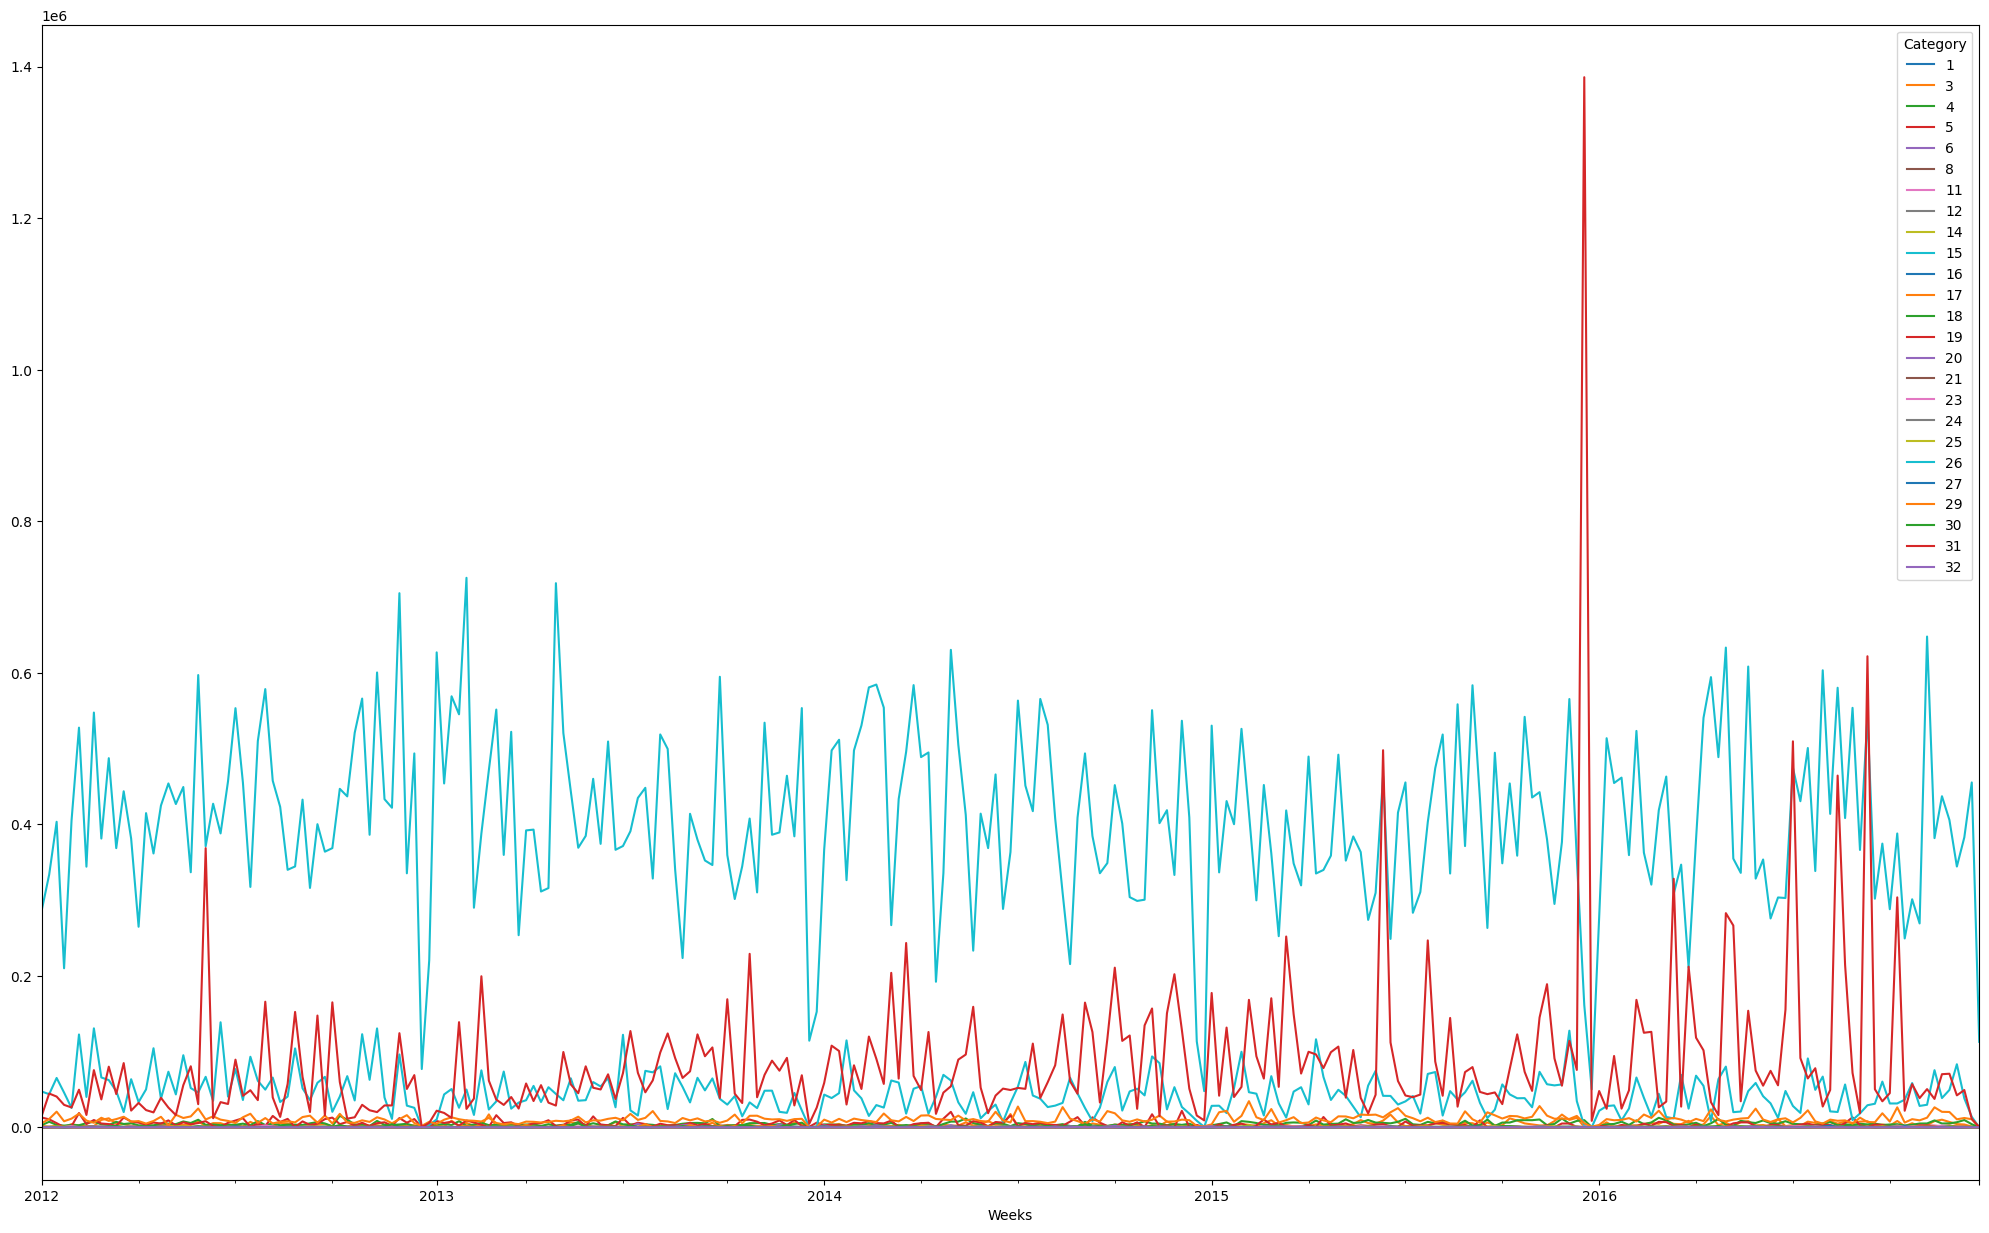

In [7]:
data_pivot = weekly.pivot(index='Weeks', columns='Category', values='Order_Demand').fillna(0)
data_pivot.plot(figsize=(25, 15))

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_pivot)

In [9]:
N = data_pivot.shape[1]
Horizon = 4 # Weeks
History = 32

In [10]:
def data():
    X = scaled_data
    inputs = []
    predictions = []
    for i in range(History, len(X)-Horizon):
        x_input = X[i-History:i]
        z = X[i:i+Horizon]
        inputs.append(x_input)
        predictions.append(z)
    return inputs, np.array(predictions)        
i,l = data()

In [11]:
i[0].shape

(32, 25)

In [12]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=4,
          horizon_len=4,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

/home/dkohlsdorf/venv/tfgpu/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Fetching 3 files: 100%|████████████████████████| 3/3 [00:00<00:00, 10763.83it/s]


In [13]:
ts_id = 1
point_forecast, experimental_quantile_forecast = tfm.forecast(
    i[ts_id].T,
    freq=[0 for _ in range(len(i[ts_id].T))],
)

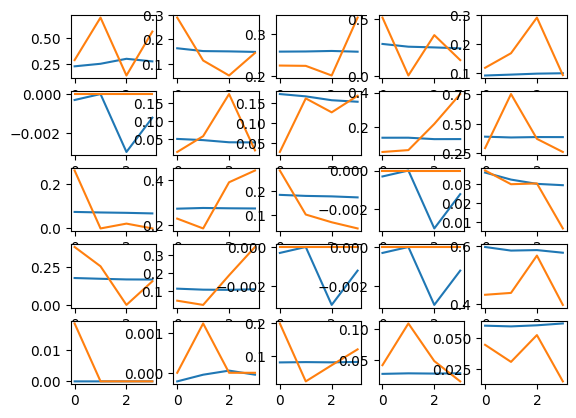

In [14]:
for seq in range(0, 25):
    plt.subplot(5, 5, seq + 1)
    plt.plot(point_forecast[seq, : ])
    plt.plot(l[ts_id,:,seq])